In [1]:
import numpy as np
import pandas as pd
import json
import os
from collections import Counter
from scipy.spatial import distance
import random 
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances
from sklearn.metrics import jaccard_similarity_score
from sklearn.cluster import KMeans, MiniBatchKMeans

from sqlalchemy_utils import database_exists, create_database
import psycopg2
from sqlalchemy import create_engine

%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
places = ['sf', 'sfyoga','sanfrancisco','classpass', 'bayarea', 'california','missiondistrict', 'socal', 
          'oc', 'newport', 'newportbeach', 'california', 'ca', 'irvine', 'tustin', 'orangecounty','missionviejo',
          'costamesa', 'orange', 'huntingtonbeach']
#'fitfam', 'lululemon', 'bestgym', 'bestworkout', 'follow','mom', 'momlife','kids',
others = ['bossbabe', 'repost', 'sffitness', 'home', 'fitness',
          'photography', 'love', '2017', 'birthday', 'happybirthday', 'tbt','entrepreneur',
         '2016', '4thofjuly', 'birthdaygirl','blogger','blackandwhite','cali', 'christmas','dogsofinstagram','fall','fashion',
          'friday','friyay','grandopening','halloween','happyholidays','happyhour', 'happynewyear','happymonday',
        'happysaturday', 'happysunday','hawaii','holiday', 'hollywood','instagram', 'la', 'laborday', 
        'labordayweekend', 'latergram','lol', 'losangeles','me','memorialday', 'monday', 
         'mondays','newyear', 'newyork','norcal','nyc','regram', 'regrann','sale', 'sandiego', 'saturday', 'saturdaymorning',
        'sffitness', 'shoplocal','sunday','thanksgiving','throwbackthursday', 'thursday','tuesday', 'twinning',
        'usa', 'vacation', 'valentinesday']

In [3]:
def CollectTags(f, inputDir):
    try:
        json_data = open(inputDir+"/"+f.lower()+"/"+f.lower()+".json")
    except:
        print ("fail", f)
        return ""
    j = json.load(json_data)
    json_data.close()
    totalTags = ""
    for i in range(len(j)):
        if 'tags' in j[i].keys():
            try:
                listostring=[]
                for b in j[i]['tags']:
                    if (b.lower() in places or b.lower() in others or b == f): continue
                    else: listostring.append(b)
                string = " " + " ".join(listostring)
                totalTags += string
            except:
                print("other",f)
                pass
    return totalTags
        


In [4]:
#closest studio zip, input zip
def miles(zip1, zip2):
    if int(zip1[:2]) < 93 and int(zip2[:2]) < 93:
        distance = random.uniform(0, 10)
    if int(zip1[:2]) < 93 and int(zip2[:2]) > 93 or int(zip1[:2]) > 93 and int(zip2[:2]) < 93:
        distance = random.uniform(0, 350)
    if int(zip1[:2]) > 93 and int(zip2[:2]) > 93:
        distance = random.uniform(0, 15)
    return distance

In [5]:
studioSF = pd.read_pickle("NewFrame_SF")
studioOC = pd.read_pickle("NewFrame_OC")

In [6]:
studioNames_SF = studioSF.columns.get_values().tolist()
newrow = [a[0] for a in studioSF.loc[1,:].tolist()]
studioSF.loc[1,:]=newrow
studioSF = studioSF.rename(columns=studioSF.iloc[1])
studioSF.loc[1,:]=studioNames_SF
studioSF.head()

,17thstreetathleticclubsf,24hourfitness,my3fit,thirdstreetboxing,abmixedmartialarts,advanceyourself,aerialartique,alkalignme,linesballet,teamaka,...,bodyfi,fitlocalfit,movesf,yogabeachsf,core40,blakefit,xtrimbollywood,SVMAA,hgxfit,koafitness
0,"[[Gyms, Cycling Classes, Bikes]]","[[Gyms, Trainers]]","[[Trainers, Cardio Classes, Nutritionists]]","[[Gyms, Trainers, Boxing]]",[[Martial Arts]],"[[Gyms, Trainers, Boot Camps]]",[[Dance Studios]],[[Gyms]],"[[Performing Arts, Dance Schools]]",[[Martial Arts]],...,"[[Pilates, Boot Camps, Trainers]]","[[Trainers, Gyms, Yoga]]","[[Gyms, Trainers]]","[[Yoga, Pilates, Cardio Classes]]","[[Pilates, Cycling Classes, Trainers]]",[[Trainers]],[[Dance Studio]],[[Marital Arts]],[[Interval Training Gyms]],"[[Martial Arts, Boxing, Gyms]]"
1,17th Street Athletic Club,24 Hour Fitness - Redwood Cit,3FIT,3rd Street Boxing Gym,AB Mixed Martial Arts Academy,Advanced Sports Performance,Aerial Artique,Alkalign Studios,Alonzo King LINES Dance Center,American Kickboxing Academy,...,bodyFi,fit GLEN fit,move-sf,yogabeach,CORE40 SoMa,BlakeFIT,Fusion Beatz,Sunnyvale Martial Arts Academy,Homegrown Crossfit,KOA Fitness Mountain View
2,19,144,57,103,57,42,32,19,115,34,...,143,28,45,20,84,32,16,29,29,55
3,5.0,3.0,5.0,5.0,5.0,5.0,4.5,4.5,4.5,4.5,...,4.5,4.5,5.0,4.5,4.5,5,5,4.5,5,5
4,94110,94063,95051,94107,94134,94070,94103,94022,94103,94087,...,94111,94131,94115,94122,94103,94114,94062,94087,94070,94043


In [7]:
studioNames_OC = studioOC.columns.get_values().tolist()
newrow = [a for a in studioOC.loc[1,:].tolist()]
studioOC.loc[1,:]=newrow
studioOC = studioOC.rename(columns=studioOC.iloc[1])
studioOC.loc[1,:]=studioNames_OC
studioOC.head()

,3dfitnessgymoc,9round,alkalignme,bakerranchyoga,barrysbootcamp,bethechangeyoga,bike2thebeattustin,bikramyogairvine,ckonorthtustin,caffeyoga,...,barmethod,thehauteroom,totalmmastudios,triadyogaandpilates,trimfitnessstudio,unionryde,vibeshotyoga,wildsideyoga,yogashaktistudio,ilovekickboxing
0,"[[Trainers, Gyms]]","[[Boxing, Trainers]]",[[Barre Classes]],[[Yoga]],"[[Trainers, Gyms, Boot Camps]]",[[Yoga]],[[Cycling Classes]],[[Yoga]],[[Kickboxing]],"[[Reiki, Yoga, Pilates]]",...,[[Barre Classes]],"[[Trainers, Gyms, Pilates]]",[[Martial Arts]],"[[Yoga, Pilates]]","[[Trainers, Gyms, Pilates]]",[[Cycling Classes]],"[[Yoga, Barre Classes, Pilates]]",[[Yoga]],"[[Yoga, Meditation Centers]]","[[Gyms, Kickboxing]]"
1,3D Fitness,9Round,Alkalign Studios,Baker Ranch Yoga,Barry's Bootcamp Irvine,Be The Change Yoga - Orange County,Bike2thebeat,Bikram Yoga Irvine,CKO Kickboxing,Caffe Yoga,...,The Bar Method,The Haute Room,Total MMA Studios,Triad Yoga & Pilates,Trim Fitness Studio,UNION Ryde,Vibes Hot Yoga,WildSide Yoga,Yoga Shakti Wellness Center,iLoveKickboxing.com
2,40,58,17,26,65,55,68,176,35,69,...,27,65,62,108,80,297,30,45,98,29
3,5.0,5.0,5.0,5.0,4.5,5.0,5.0,4.5,5.0,5.0,...,5.0,5.0,4.5,5.0,5.0,5.0,5.0,5.0,4.5,5.0
4,92602,92626,92620,92630,92612,92602,92782,92620,92653,92782,...,92780,92782,92780,92660,92630,92660,92663,92708,92612,92708


In [8]:
inputDir_SF = "SiliconValley"
inputDir_OC = "SampleSet"

In [9]:
studioSF.rename(columns={'bodytemptyoga': 'bodytempyoga'}, inplace=True)
studioSF.rename(columns={'eskabodaansep': 'eskabodaan'}, inplace=True)
studioSF.rename(columns={'rougeandsaintfitness':'rogueandsaintfitness'}, inplace=True)
studioSF.rename(columns={'B3strong':'b3strong'}, inplace=True)
studioSF.rename(columns={'SVMAA':'svmaa'}, inplace=True)
studioOC.rename(columns={'freedomride':'freedomfoxes'}, inplace=True)

In [10]:
titles_SF = studioSF.columns.get_values().tolist()# if a in os.listdir(inputDir)]

studioNames_SF = [a for a in studioSF.loc[1,:].values.tolist()]
genres_SF = [a for a in studioSF.loc[0,:].values.tolist()]
hashtags_SF = [CollectTags(f, inputDir_SF) for f in titles_SF]
#ranks_SF = [i for i in range(len(hashtags_SF))]
reviews_SF = [a for a in studioSF.loc[2,:].values.tolist()]
stars_SF = [a for a in studioSF.loc[3,:].values.tolist()]
zip_SF = [a for a in studioSF.loc[4,:].values.tolist()]
print(len(titles_SF), len(genres_SF), len(studioNames_SF), len(hashtags_SF))

151 151 151 151


In [13]:
titles_OC = studioOC.columns.get_values().tolist()# if a in os.listdir(inputDir)]

studioNames_OC = [a for a in studioOC.loc[1,:].values.tolist()]
genres_OC = [a for a in studioOC.loc[0,:].values.tolist()]
hashtags_OC = [CollectTags(f, inputDir_OC) for f in titles_OC]
#ranks_OC = [i+len(ranks_SF) for i in range(len(hashtags_OC))]
reviews_OC = [a for a in studioOC.loc[2,:].values.tolist()]
stars_OC = [a for a in studioOC.loc[3,:].values.tolist()]
zip_OC = [a for a in studioOC.loc[4,:].values.tolist()]
print(len(titles_OC), len(genres_OC), len(studioNames_OC), len(hashtags_OC))


54 54 54 54


In [15]:
savedFrame_SF = pd.DataFrame({'name': titles_SF, 'studioName': studioNames_SF, 'type': genres_SF, 'hashtags': hashtags_SF,  'review': reviews_SF, 'star': stars_SF, 'zip': zip_SF})
savedFrame_OC = pd.DataFrame({'name': titles_OC, 'studioName': studioNames_OC, 'type': genres_OC, 'hashtags': hashtags_OC,  'review': reviews_OC, 'star': stars_OC, 'zip': zip_OC})

In [16]:
totDF = pd.concat([savedFrame_SF, savedFrame_OC])
#print(len(totDF.index.tolist()), len(savedFrame_SF.index.tolist()),len(savedFrame_OC.index.tolist()))
#print(len(hashtags_OC), len(hashtags_SF))
totDF.head()

,hashtags,name,review,star,studioName,type,zip
0,17thstreetfitnesschallenge indoorcycling wekn...,17thstreetathleticclubsf,19,5.0,17th Street Athletic Club,"[[Gyms, Cycling Classes, Bikes]]",94110
1,funning lafitness equinox planetfitness cali...,24hourfitness,144,3.0,24 Hour Fitness - Redwood Cit,"[[Gyms, Trainers]]",94063
2,stickmobility strongcore exercise body...,my3fit,57,5.0,3FIT,"[[Trainers, Cardio Classes, Nutritionists]]",95051
3,davesclass daveisamazing boxingmyfirstlove g...,thirdstreetboxing,103,5.0,3rd Street Boxing Gym,"[[Gyms, Trainers, Boxing]]",94107
4,mma abmma muaythai bjj brazilianjiujitsu qu...,abmixedmartialarts,57,5.0,AB Mixed Martial Arts Academy,[[Martial Arts]],94134


In [17]:
totDF[totDF['name']=='corepoweryoga']
totDF.drop(14, inplace=True)
totDF[totDF['name']=='corepoweryoga']

,hashtags,name,review,star,studioName,type,zip
36,liveyourpower twistoflemons sponsored yogavi...,corepoweryoga,107,4.5,CorePower Yoga,[[Yoga]],95128


In [18]:
totDF[totDF['studioName']=='Alkalign Studios']
totDF.drop(7, inplace=True)
totDF[totDF['studioName']=='Alkalign Studios']

,hashtags,name,review,star,studioName,type,zip
2,alkalignforlife alkaligninfinity LosAltos fas...,alkalignme,17,5.0,Alkalign Studios,[[Barre Classes]],92620


In [19]:
totDF['rank']=[i for i in range(len(totDF['studioName'].tolist()))]

In [20]:
totDF.head()

,hashtags,name,review,star,studioName,type,zip,rank
0,17thstreetfitnesschallenge indoorcycling wekn...,17thstreetathleticclubsf,19,5.0,17th Street Athletic Club,"[[Gyms, Cycling Classes, Bikes]]",94110,0
1,funning lafitness equinox planetfitness cali...,24hourfitness,144,3.0,24 Hour Fitness - Redwood Cit,"[[Gyms, Trainers]]",94063,1
2,stickmobility strongcore exercise body...,my3fit,57,5.0,3FIT,"[[Trainers, Cardio Classes, Nutritionists]]",95051,2
3,davesclass daveisamazing boxingmyfirstlove g...,thirdstreetboxing,103,5.0,3rd Street Boxing Gym,"[[Gyms, Trainers, Boxing]]",94107,3
4,mma abmma muaythai bjj brazilianjiujitsu qu...,abmixedmartialarts,57,5.0,AB Mixed Martial Arts Academy,[[Martial Arts]],94134,4


In [41]:
totDF = pd.read_pickle("FinalDF")

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000, min_df=0.15, ngram_range=(1,1))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(totDF['hashtags'].tolist())

CPU times: user 1.43 s, sys: 47.8 ms, total: 1.48 s
Wall time: 1.49 s


In [43]:
terms = tfidf_vectorizer.get_feature_names()
#print(terms)

In [60]:
dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=terms, index=totDF['title'].tolist()) #name
#print(df.head(10))
s = pd.Series(df.loc['pelofitness'])
s[s > 0].sort_values(ascending=False)[:10]

cycle            0.434214
spin             0.397259
endurance        0.342069
peace            0.298892
loveyourself     0.281001
indoorcycling    0.280450
trx              0.268802
staystrong       0.190935
motivation       0.177987
dedication       0.170669
Name: pelofitness, dtype: float64

In [46]:
dist = 1 - cosine_similarity(tfidf_matrix)

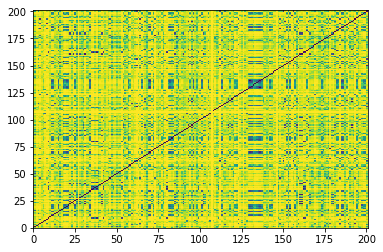

In [47]:
plt.pcolor(dist)

In [26]:
#(totDF.loc[totDF['studioName']=="Triad Yoga & Pilates"])['zip'].values[0]

In [27]:
def similarities(M, studio, names, nearzip, distaway=10):
    ind = names.index(studio)
    zip1 = (totDF.loc[totDF['name']==studio])['zip'].values[0]
    sims = M[ind][:]
    ordered = [(isim, sim) for isim, sim in enumerate(sims)]
    sortd = sorted(ordered, key=lambda tup: tup[1])
    newsorted=[]
    for i, s in enumerate(sortd):
        studio_name = (studioNames_SF+studioNames_OC)[sortd[i][0]]
        zip2 = (totDF.loc[totDF['studioName']==studio_name])['zip'].values[0]
        if miles(str(zip2), str(nearzip)) < distaway:
            newsorted.append(s)
    return newsorted #sortd

In [ ]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = kmeans.cluster_centers_
    labels  = kmeans.labels_


    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape
    
    X = X.toarray()
    
    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], centers[i].reshape(1,-1), 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2.) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2.) for i in range(m)]) - const_term

    return(BIC)

In [51]:
bics =[]
for n in range(2, 20):
    kmeans = KMeans(n_clusters=n, n_init=100)
    kmeans.fit(tfidf_matrix)
    bics.append(compute_bic(kmeans,tfidf_matrix))   

([], <a list of 0 Text yticklabel objects>)

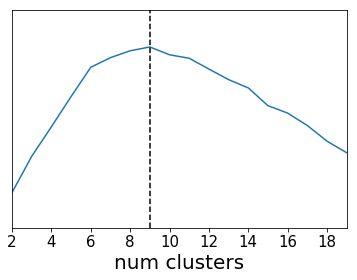

In [52]:
plt.plot(np.arange(2, 20), bics)

plt.plot(9.*np.ones(2), [np.min(bics)*0.99, np.max(bics)*1.01], linestyle = "--", c='black')
plt.xlim([2,19])
plt.ylim([np.min(bics)*0.99, np.max(bics)*1.01])
plt.xlabel("num clusters", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks([])
#plt.ylabel("BIC")

In [48]:
num_clusters = 9 

km = KMeans(n_clusters=num_clusters, n_init=100)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()


CPU times: user 33.2 s, sys: 1.34 s, total: 34.5 s
Wall time: 19.1 s


In [51]:
#studios = {'title': totDF['name'].tolist(), 'rank': totDF['rank'].tolist(), 'hashtags': totDF['hashtags'].tolist(), 'cluster': clusters,  'genre': totDF['type'].tolist(), 'studioName': totDF['studioName'].tolist(), 'review': totDF['review'].tolist(), 'star': totDF['star'].tolist(), 'zip': totDF['zip'].tolist()}
studios = {'title': totDF['title'].tolist(), 'rank': totDF['rank'].tolist(), 'hashtags': totDF['hashtags'].tolist(), 'cluster': clusters,  'genre': totDF['genre'].tolist(), 'studioName': totDF['studioName'].tolist()}

frame = pd.DataFrame(studios, index = [clusters] , columns = ['rank', 'title', 'cluster','genre', 'studioName', 'hashtags', 'zip'])

In [52]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

cluster_names = {}
cluster_genres = {}
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    cluster_names[i]=""
    cluster_genres[i]=[]
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        cluster_names[i] += terms[ind].split(' ')[0] + " "
        print(' %s' % terms[ind].split(' ')[0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d group:" % i, end='')
    for g in frame.loc[i]['genre'].values.tolist():
        cluster_genres[i] += g
        print(' %s,' % g, end='')
    print() #add whitespace
    print() #add whitespace
    
print()

Top terms per cluster:

Cluster 0 words: kickboxing, boxing, workout, gym, fit, muaythai,

Cluster 0 titles: thirdstreetboxing, bstreetboxing, hitfitsf, hwarangkwansf, impactkbf, studiokickspaloalto, titleboxing, 9round, ckonorthtustin, ilovekickboxing,

Cluster 0 group: [['Gyms', 'Trainers', 'Boxing']], [['Boxing']], [['Trainers', 'Gyms']], [['Martial Arts']], [['Boxing', 'Kickboxing', 'Cardio Classes']], [['Martial Arts']], [['Trainers', 'Kickboxing']], [['Boxing', 'Trainers']], [['Kickboxing']], [['Gyms', 'Kickboxing']],

Cluster 1 words: barre, workout, yoga, cycle, cardio, fitfam,

Cluster 1 titles: cardiotone, flexfusionstudios, liftbbb, popphysique, purebarre, barmethod, thedaileymethod, alkalignme, cardiobarre, enerjibarre, neaumixfit, pureempower, barmethod,

Cluster 1 group: [['Cardio Classes', 'Cycling Classes']], [['Barre Classes', 'Yoga', 'Boot Camps']], [['Trainers', 'Barre Classes', 'Cycling Classes']], [['Barre Classes', 'Dance Studios']], [['Barre Classes']], [['Barre 

Pilates:
bluesparrowpilates, bodychemistrystudio, bodyrok, burnpilatessf, centeredbodypilates, ehspilates, mightypilates, onpointesf, pilatesproworks, rocksaltfitness, clubpilates, corereform, fitpilatesstudio, pilatespluscycle, pilatesonpurpose,

Cluster 0 group: ['Pilates'], ['Pilates'], [['Some Yoga', 'Pilates', 'Cycling Classes']], [['Gyms - free weights/HIIT', 'Pilates']], ['Pilates'], [['Pilates', 'Rehabilitation Center']], [['Pilates', more intense]], [['Yoga','Pilates', 'Boxing']], [['Pilates', 'intense]], [['Pilates']], [['Pilates', 'cardio']], ['Pilates'], [['Pilates', 'Cycling Classes']], [['Pilates', 'Yoga']],

Cluster 1 words: yoga, yogaeverydamnday, namaste, yogalove, vinyasa, meditation,

Cluster 1 titles: astayoga, avalonyoga, baptisteyoga, bethechangeyoga, beingyogaburlingame, bendsf, bikramyoga, bodytempyoga, corepoweryoga, glowyogasf, graceyogamillbrae, justbreatheyogarivermark, laughinglotussf, livelotus, lovestoryyoga, mynulifstudio, missionyogasf, moxieyogafitness, nandiyoga, ompowersf, oceanbeachyogasf, peacebankyoga, prajnacommunity, purushayoga, ravenfitness, ritualhotyoga, samyamayogacenter, studiorincon, thecentersf, mindfulbodymysore, thepadstudios, vibeyogaca, yogaflowsf, yogagardensf, goyhc, yogamayusf, yogasourcepaloalto, yogatreesf, yogaflowsf, yogaworkspaloalto, yogabeachsf, core40, bakerranchyoga, bethechangeyoga, bikramyogairvine, caffeyoga, corepoweryoga, ekamyoga, mixxyoga, rayoga, radianthotyoga, spectrayoga, stellalunayoga, sunsparkyoga, triadyogaandpilates, vibeshotyoga, wildsideyoga, yogashaktistudio,

Cluster 1 group: [['Yoga']], [['Yoga', 'Pilates']], [['Yoga']], [['Yoga', 'Ayurveda', 'Pilates']], [['Yoga']], [['Yoga']], [['Yoga']], [['Yoga']], [['Yoga']], [['Yoga', 'Pilates', 'Massage']], [['Yoga', 'Meditation Centers']], [['Yoga']], [['Yoga']], [['Yoga']], [['Yoga']], [['Yoga', 'Pilates', 'Nutritionists']], [['Yoga', 'Massage Therapy', 'Pilates']], [['Yoga']], [['Yoga']], [['Gyms', 'Yoga', 'Trainers']], [['Yoga']], [['Yoga', 'Pilates']], [['Yoga', 'Meditation Centers']], [['Yoga', 'Trainers', 'Massage']], [['Yoga', 'Dance Studios']], [['Yoga']], [['Yoga', 'Specialty Schools']], [['Yoga', 'Dance Studios', 'Trainers']], [['Venues &amp; Event Spaces', 'Tea Rooms', 'Yoga']], [['Massage', 'Yoga']], [['Yoga', 'Pilates']], [['Yoga', 'Pilates', 'Meditation Centers']], [['Yoga']], [['Trainers', 'Yoga']], [['Yoga']], [['Yoga', 'Boot Camps']], [['Yoga']], [['Yoga']], [['Yoga', 'Pilates']], [['Yoga']], [['Yoga', 'Pilates', 'Cardio Classes']], [['Pilates', 'Cycling Classes', 'Trainers']], [['Yoga']], [['Yoga']], [['Yoga']], [['Reiki', 'Yoga', 'Pilates']], [['Yoga']], [['Yoga']], [['Yoga']], [['Yoga', 'Pilates']], [['Yoga']], [['Yoga', 'Pilates', 'Meditation Centers']], [['Yoga', 'Reiki', 'Ayurveda']], [['Yoga', 'Pilates']], [['Yoga', 'Pilates']], [['Yoga', 'Barre Classes', 'Pilates']], [['Yoga']], [['Yoga', 'Meditation Centers']],

Cluster 2 words: dance, fitness, workout, hiphop, flexibility, splits,

Cluster 2 titles: advanceyourself, aerialartique, linesballet, bmifitness, brienshampfitbodybootcamp, doonyasf, elevategroupfitness, equinoxpaloalto, iheartcore, poletential, raestudios, sfpoleanddance, sanchezstreetstudio, sheilakelleysfactor, tayloryourfitness, uforiastudios, undergroundfitnessii, vrv3studios, xtrimbollywood, svmaa, studiofixx,

Cluster 2 group: [['Gyms', 'Trainers', 'Boot Camps']], [['Dance Studios']], [['Performing Arts', 'Dance Schools']], [['Trainers', 'Gyms']], [['Nutritionists', 'Boot Camps']], [['Dance Studios', 'Cardio Classes']], [['Yoga', 'Pilates', 'Barre Classes']], [['Gyms', 'Day Spas', 'Sports Clubs']], [['Pilates', 'Gyms']], [['Trainers', 'Dance Studios', 'Pole Dancing Classes']], [['Dance Studios']], [['Pole Dancing Classes', 'Dance Studios', 'Yoga']], [['Pilates']], [['Pole Dancing Classes']], [['Barre Classes']], [['Dance Studios', 'Cycling Classes']], [['Trainers', 'Dance Studios', 'Circuit Training Gyms']], [['Pole Dancing Classes', 'Dance Studios', 'Trainers']], [['Dance Studio']], [['Marital Arts']], [['Dance Studios', 'Barre Classes', 'Pilates']],

Cluster 3 words: crossfit, weightlifting, fitness, fitfam, wod, fitspo,

Cluster 3 titles: amitycrossfit, cfgoldengate, crossfitpaloalto, teamcfoc, crossfitsj, elevatefp, fnsstrong, flagshipapc, monarchcrossfit, reddotfitness, crossfittustin, crossfitinsanity,

Cluster 3 group: [['Gyms', 'Gymnastics', 'Kickboxing']], [['Interval Training Gyms']], [['Interval Training Gyms']], [['Boot Camps', 'Trainers']], [['Interval Training Gyms']], [['Gyms', 'Trainers']], [['Trainers', 'Gyms', 'Boot Camps']], [['Interval Training Gyms']], [['Gyms', 'Trainers']], [['Trainers']], [['Trainers', 'Interval Training Gyms']], [['Trainers', 'Gyms']],

Cluster 4 words: kickboxing, boxing, fitness, workout, gym, fit,

Cluster 4 titles: thirdstreetboxing, bstreetboxing, hitfitsf, hwarangkwansf, impactkbf, studiokickspaloalto, titleboxing, 9round, ckonorthtustin, ilovekickboxing,

Cluster 4 group: [['Gyms', 'Trainers', 'Boxing']], [['Boxing']], [['Trainers', 'Gyms']], [['Martial Arts']], [['Boxing', 'Kickboxing', 'Cardio Classes']], [['Martial Arts']], [['Trainers', 'Kickboxing']], [['Boxing', 'Trainers']], [['Kickboxing']], [['Gyms', 'Kickboxing']],

Cluster 5 words: mma, bjj, muaythai, kickboxing, ufc, fitness,

Cluster 5 titles: abmixedmartialarts, teamaka, evolvetrainingcenter, knoxxmartialartsandfitness, marconascimento, tosettiinstitute, koafitness, carrillomuaythai, 5elementsbruce, ockmma, onejiujitsu, roundersmma, teamoyama, totalmmastudios,

Cluster 5 group: [['Martial Arts']], [['Martial Arts']], [['Martial Arts', 'Trainers']], [['Martial Arts', 'Boxing']], [['Brazilian Jiu-jitsu']], [['Trainers', 'Gyms', 'Martial Arts']], [['Martial Arts, Boxing, Gyms']], [['Gyms', 'Boxing', 'Trainers']], [['Martial Arts', 'Yoga', 'Gyms']], [['Martial Arts', 'Gyms', 'Boxing']], [['Kickboxing', 'Brazilian Jiu-jitsu']], [['Martial Arts', 'Boxing', 'Gyms']], [['Martial Arts', 'Gyms']], [['Martial Arts']],

Cluster 6 words: fitness, fitfam, workout, gym, fit, personaltrainer,

Cluster 6 titles: 24hourfitness, my3fit, ascendbody, barrysbootcamp, basecampsf, bodybyburesh, burnshakeroll, citysportsclub, corestudiospx, crunchgym, eskabodaan, f45, fitforlifesolutions, fitness19, teamft, fitnessurbano, functionalcorefitness, livefitgym, method3fitness, mintconditionfitness, mobiusfit, orangetheoryfitness, physiquemagnifique, planetgranite, rogueandsaintfitness, rowclubsf, sickfitbootcamp, studiokfit, swingsf, fieldfitness, b3strong, bodyfi, fitlocalfit, movesf, blakefit, hgxfit, 3dfitnessgymoc, barrysbootcamp, fitnessonfire, fitwall, hdxfit, kaiafit, ocfit, orangetheoryfitness, 12life, thehauteroom, trimfitnessstudio,

Cluster 6 group: [['Gyms', 'Trainers']], [['Trainers', 'Cardio Classes', 'Nutritionists']], [['Trainers', 'Gyms', 'Massage Therapy']], [['Trainers', 'Gyms', 'Boot Camps']], [['Gyms', 'Boxing', 'Boot Camps']], [['Trainers']], [['Pilates', 'Gyms', 'Trainers']], [['Sports Clubs', 'Gyms', 'Trainers']], [['Pilates', 'Gyms', 'Trainers']], [['Gyms', 'Trainers', 'Yoga']], [['Self-defense Classes', 'Boxing', 'Brazilian Jiu-jitsu']], [['Trainers']], [['Trainers']], [['Gyms', 'Boot Camps', 'Pilates']], [['Gyms', 'Trainers']], [['Gyms', 'Trainers']], [['Trainers', 'Gyms']], [['Chiropractors', 'Trainers', 'Gyms']], [['Trainers', 'Gyms', 'Boot Camps']], [['Trainers', 'Gyms', 'Boot Camps']], [['Weight Loss Centers', 'Gyms', 'Trainers']], [['Trainers', 'Gyms', 'Boot Camps']], [['Gyms', 'Martial Arts', 'Trainers']], [['Gyms', 'Yoga', 'Climbing']], [['Boot Camps', 'Pilates', 'Gyms']], [['Gyms', 'Trainers']], [['Trainers', 'Boot Camps']], [['Gyms']], [['Trainers', 'Gyms', 'Boot Camps']], [['Trainers', 'Interval Training Gyms']], [['Barre Classes', 'Pilates', 'Yoga']], [['Pilates', 'Boot Camps', 'Trainers']], [['Trainers', 'Gyms', 'Yoga']], [['Gyms', 'Trainers']], [['Trainers']], [['Interval Training Gyms']], [['Trainers', 'Gyms']], [['Trainers', 'Gyms', 'Boot Camps']], [['Gyms', 'Trainers']], [['Trainers', 'Gyms']], [['Boot Camps', 'Gyms', 'Trainers']], [['Trainers', 'Gyms', 'Nutritionists']], [['Trainers', 'Gyms']], [['Trainers', 'Gyms', 'Boot Camps']], [['Trainers', 'Nutritionists', 'Interval Training Gyms']], [['Trainers', 'Gyms', 'Pilates']], [['Trainers', 'Gyms', 'Pilates']],

Cluster 7 words: indoorcycling, spin, cycling, spinclass, fitness, spinning,

Cluster 7 titles: 17thstreetathleticclubsf, flywheel, lavationstudio, momentumcyclingstudio, pelofitness, revelryfitness, soulcycle, transformmv, undisputedboxinggym, bike2thebeattustin, freedomfoxes, unionryde,

Cluster 7 group: [['Gyms', 'Cycling Classes', 'Bikes']], [['Cycling Classes']], [['Gyms', 'Cycling Classes']], [['Cycling Classes']], [['Gyms', 'Cardio Classes', 'Cycling Classes']], [['Cycling Classes', 'Yoga', 'Kickboxing']], [['Cycling Classes']], [['Pilates', 'Gyms', 'Trainers']], [['Martial Arts', 'Gyms', 'Boxing']], [['Cycling Classes']], [['Cycling Classes']], [['Cycling Classes']],

Cluster 8 words: barre, fitness, workout, pilates, yoga, cycle,

Cluster 8 titles: alkalignme, avantbarre, cardiotone, flexfusionstudios, liftbbb, mntstudio, popphysique, purebarre, barmethod, thedaileymethod, alkalignme, cardiobarre, enerjibarre, neaumixfit, pureempower, barmethod,

Cluster 8 group: [['Gyms']], [['Barre Classes']], [['Cardio Classes', 'Cycling Classes']], [['Barre Classes', 'Yoga', 'Boot Camps']], [['Trainers', 'Barre Classes', 'Cycling Classes']], [['Pilates', 'Barre Classes', 'Yoga']], [['Barre Classes', 'Dance Studios']], [['Barre Classes']], [['Barre Classes']], [['Barre Classes']], [['Barre Classes']], [['Barre Classes', 'Cardio Classes', 'Gyms']], [['Yoga', 'Barre Classes', 'Boxing']], [['Pilates', 'Cycling Classes', 'Barre Classes']], [['Barre Classes']], [['Barre Classes']],

In [31]:
cluster_category = {}
for i in range(num_clusters):
    wordCount = Counter([x for sublist in cluster_genres[i] for x in sublist])
    print(dict(wordCount))
    cluster_category[i]=wordCount.most_common(1)[0][0]
print (cluster_category)

{'Gyms': 4, 'Trainers': 4, 'Boxing': 4, 'Martial Arts': 3, 'Kickboxing': 4, 'Cardio Classes': 1, 'Yoga': 1}
{'Yoga': 54, 'Pilates': 17, 'Ayurveda': 2, 'Massage': 3, 'Meditation Centers': 5, 'Nutritionists': 1, 'Massage Therapy': 1, 'Gyms': 1, 'Trainers': 5, 'Dance Studios': 2, 'Specialty Schools': 1, 'Venues &amp; Event Spaces': 1, 'Tea Rooms': 1, 'Boot Camps': 1, 'Cardio Classes': 1, 'Cycling Classes': 1, 'Reiki': 2, 'Barre Classes': 1}
{'Gyms': 6, 'Gymnastics': 1, 'Kickboxing': 1, 'Interval Training Gyms': 5, 'Boot Camps': 2, 'Trainers': 7}
{'Pilates': 16, 'Trainers': 6, 'Gyms': 5, 'Cycling Classes': 2, 'Rehabilitation Center': 1, 'Barre Classes': 2, 'Boxing': 1, 'Boot Camps': 1, 'Yoga': 2}
{'Trainers': 9, 'Cardio Classes': 2, 'Nutritionists': 2, 'Dance Studios': 9, 'Performing Arts': 1, 'Dance Schools': 1, 'Gyms': 7, 'Boxing': 1, 'Boot Camps': 4, 'Yoga': 4, 'Pilates': 4, 'Barre Classes': 4, 'Day Spas': 1, 'Sports Clubs': 1, 'Cycling Classes': 2, 'Pole Dancing Classes': 4, 'Circuit T

In [32]:
frame.head()

,rank,title,cluster,genre,studioName,hashtags,zip
8,0,17thstreetathleticclubsf,8,"[[Gyms, Cycling Classes, Bikes]]",17th Street Athletic Club,17thstreetfitnesschallenge indoorcycling wekn...,94110
5,1,24hourfitness,5,"[[Gyms, Trainers]]",24 Hour Fitness - Redwood Cit,funning lafitness equinox planetfitness cali...,94063
4,2,my3fit,4,"[[Trainers, Cardio Classes, Nutritionists]]",3FIT,stickmobility strongcore exercise body...,95051
0,3,thirdstreetboxing,0,"[[Gyms, Trainers, Boxing]]",3rd Street Boxing Gym,davesclass daveisamazing boxingmyfirstlove g...,94107
7,4,abmixedmartialarts,7,[[Martial Arts]],AB Mixed Martial Arts Academy,mma abmma muaythai bjj brazilianjiujitsu qu...,94134


In [33]:
#frame.to_pickle("FinalDF")

frame[frame['studioName']=='CORE40 SoMa']
#frame['zip']

nearZip = 94306
faraway = 10
mm = similarities(dist, 'mixxyoga', titles_SF+titles_OC, nearZip, faraway)
mostsimilar = (studioNames_SF+studioNames_OC)[mm[1][0]]
print(mostsimilar)

In [35]:
#frame[frame['studioName']=='Core Power']
#frame[frame['title']=='corepoweryoga']
#frame['zip']

In [36]:

def TP_FP(clusterWord, keywordGroups):
    TP = 0
    FP = 0
    for i in keywordGroups:
        if clusterWord in i: TP+=1
        else: FP+=1
    return TP, FP

def FN(clusterWord, keywordGroups, keywordNonCluster):
    TP = 0
    FN = 0
    for i in keywordNonCluster:
        if clusterWord in [x for sublist in i for x in sublist]: FN+=1
    return FN

def F1(TP, FP, FN):
    P = float(TP)/(float(TP)+float(FP))
    R = float(TP)/(float(TP)+float(FN))
    return 2.*P*R/(R+P)


In [37]:
totTp, totFp, totFn = 0, 0, 0
for cluster in range(num_clusters):
    clusterWord = cluster_category[cluster]
    print (clusterWord)
    #P = precision(clusterWord, cluster_genres[cluster])
    otherLists = [cluster_genres[i] for i in range(num_clusters) if i != cluster]
    #R = recall(clusterWord, cluster_genres[cluster], otherLists)
    Tp, Fp = TP_FP(clusterWord, cluster_genres[cluster])
    totTp+=Tp
    totFp+=Fp
    Fn = FN(clusterWord, cluster_genres[cluster], otherLists)
    totFn+=Fn
    #print (P, R)
print(F1(totTp, totFp, totFn))

Gyms
Yoga
Trainers
Pilates
Trainers
Trainers
Barre Classes
Martial Arts
Cycling Classes
0.7609756097560977


In [53]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: 'cyan', 5:'blue', 6:'#e7e329',  7:'#c729e7', 8: '#8ee729', 9:'magenta'}#66a61e

In [54]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

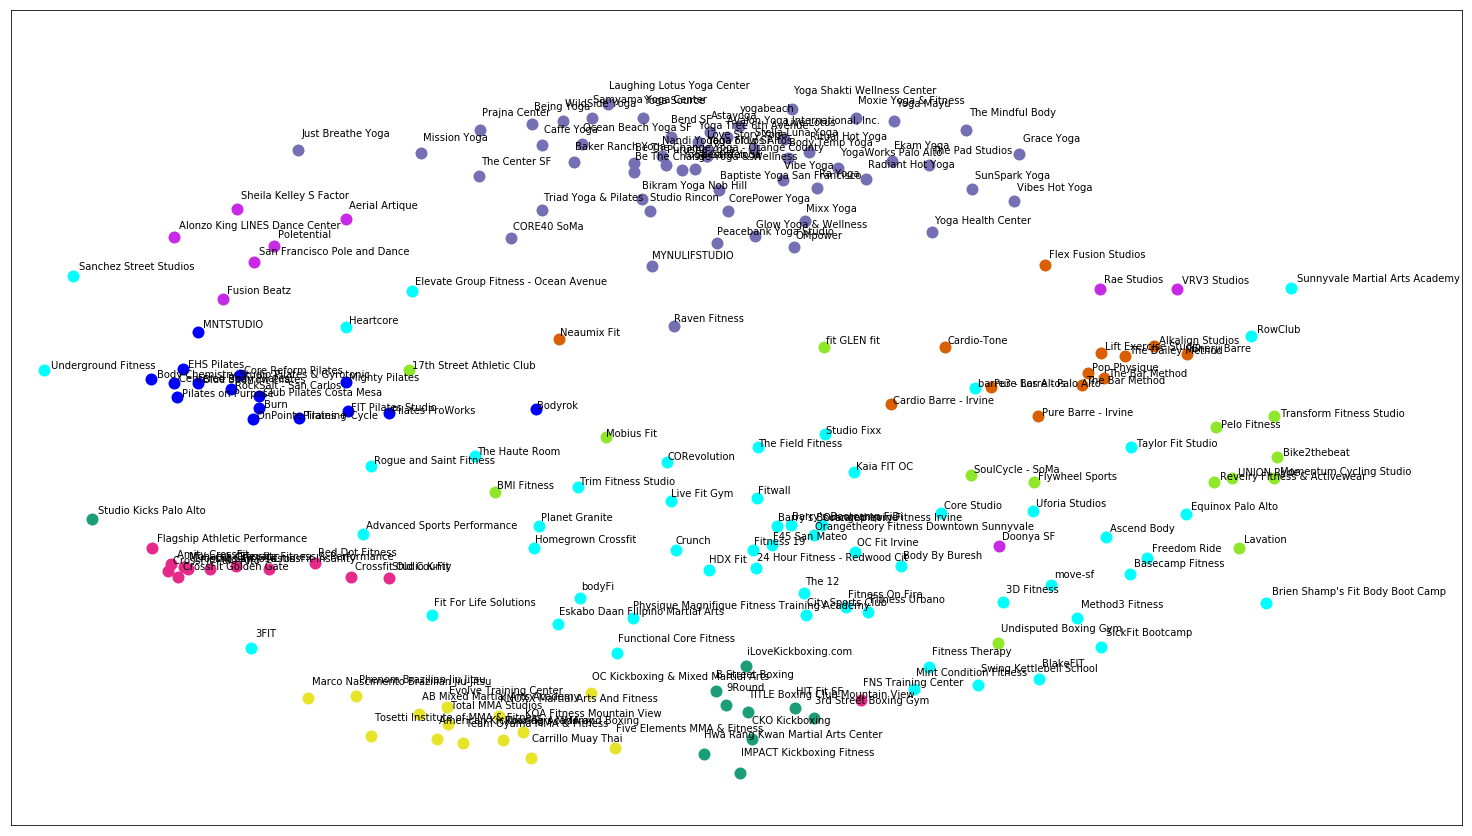

In [55]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=frame['studioName'].tolist())) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(26, 15)) # set size 15
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#cluster_names[name], cluster_category[name]
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_category[name]+": "+cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    


ax.set_xlim([-0.87,1.01] )
ax.set_ylim([-0.9,0.9])

for i in range(len(df)):
    xscalefactor = 1.01 if df.iloc[i]['x'] >0 else 0.99
    yscalefactor = 1.05 if df.iloc[i]['y'] >0 else 0.95
    ax.text(df.iloc[i]['x']*xscalefactor, df.iloc[i]['y']*yscalefactor, df.iloc[i]['title'], size=10)  

#add label in x,y position with the label as the film title







In [ ]:
'''
for i in range(len(df)):
    xscalefactor = 1.01 if df.iloc[i]['x'] >0 else 0.99
    yscalefactor = 1.05 if df.iloc[i]['y'] >0 else 0.95
    ax.text(df.iloc[i]['x']*xscalefactor, df.iloc[i]['y']*yscalefactor, df.iloc[i]['title'], size=10)  
box = ax.get_position()
ax.set_position([box.x0, box.y0+ box.height * 0.1,
                 box.width, box.height * 0.9])


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.001),
          fancybox=True,  ncol = 1, prop={'size': 20})
for name, group in groups:
    print(cluster_category[name]+": "+cluster_names[name])


'''